In [1]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from glob import glob
from nilearn import plotting
from nilearn import datasets

from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix

In [2]:
task_label = 'tonecat'

project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
#bidsroot = os.path.join(project_dir,'data_bids')
bidsroot = os.path.join(project_dir, 'archive', 'data_bids_noIntendedFor')
deriv_dir = os.path.join(project_dir, 'derivatives', 'fmriprep_noSDC')

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')
if not os.path.exists(nilearn_dir):
        os.makedirs(nilearn_dir)

## Second-level analyses

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [4]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT01', 'sub-FLT16',
               'sub-FLT19', 'sub-FLT20', 
               'sub-FLT25', 'sub-FLT26', 
               'sub-FLT02',
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index,
                     inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], 
                            ignore_index=True, 
                            inplace=True)

In [5]:
participants_fpath

'/bgfs/bchandrasekaran/krs228/data/FLT/archive/data_bids_noIntendedFor/participants.tsv'

In [6]:
print(participants_df)

   participant_id  age sex         group
0       sub-FLT03   25   F      Mandarin
1       sub-FLT04   21   F  non-Mandarin
2       sub-FLT05   26   M      Mandarin
3       sub-FLT06   21   F  non-Mandarin
4       sub-FLT07   22   M      Mandarin
5       sub-FLT08   23   F      Mandarin
6       sub-FLT09   30   F  non-Mandarin
7       sub-FLT10   23   F      Mandarin
8       sub-FLT11   20   F  non-Mandarin
9       sub-FLT12   20   F  non-Mandarin
10      sub-FLT13   23   F  non-Mandarin
11      sub-FLT14   23   M  non-Mandarin
12      sub-FLT15   22   M      Mandarin
13      sub-FLT17   29   F      Mandarin
14      sub-FLT18   24   M      Mandarin
15      sub-FLT21   21   M      Mandarin
16      sub-FLT24   20   M      Mandarin


In [7]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

#### Create design matrixes

In [8]:
# difference between groups
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)
design_mat_groupdiff = pd.DataFrame({'Mand': groups_label,
                                     'NMan': groups_label,
                                    }
                                   )

design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'Mandarin'] = 1
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'non-Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'non-Mandarin'] = 1
design_mat_groupdiff = design_mat_groupdiff.astype('int')
print(design_mat_groupdiff)

    Mand  NMan
0      1     0
1      0     1
2      1     0
3      0     1
4      1     0
5      1     0
6      0     1
7      1     0
8      0     1
9      0     1
10     0     1
11     0     1
12     1     0
13     1     0
14     1     0
15     1     0
16     1     0


### Get files

In [9]:
contrast_label = 'sound'
fwhm = 1.5
space_label = 'MNI152NLin2009cAsym'
mask_label = 'gm' # 'gm-thr90'
cond_label = 'tone'
search_label = 'searchlight_radius-9'
l1_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 'level-1_fwhm-%.02f'%fwhm)
l1_fnames = sorted(glob(l1_dir+'/sub-*_space-%s/%s/*mask-%s_cond-%s_searchlight.nii.gz'%(space_label, search_label, mask_label, cond_label)))


In [10]:
l1_fnames_groupdiff = [sorted(glob(l1_dir+'/%s_space-%s/%s/*mask-%s_cond-%s_searchlight.nii.gz'%(sub_id, space_label, search_label,
                                                                                                 mask_label, cond_label)))[0] for sub_id in subjects_label]

In [11]:
l1_fnames_groupdiff[:5]

['/bgfs/bchandrasekaran/krs228/data/FLT/archive/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT03_space-MNI152NLin2009cAsym/searchlight_radius-9/sub-FLT03_space-MNI152NLin2009cAsym_mask-gm_cond-tone_searchlight.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/archive/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-MNI152NLin2009cAsym/searchlight_radius-9/sub-FLT04_space-MNI152NLin2009cAsym_mask-gm_cond-tone_searchlight.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/archive/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT05_space-MNI152NLin2009cAsym/searchlight_radius-9/sub-FLT05_space-MNI152NLin2009cAsym_mask-gm_cond-tone_searchlight.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/archive/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT06_space-MNI152NLin2009cAsym/searchlight_radius-9/sub-FLT06_space-MNI152NLin2009cAsym_mask-gm_cond-tone_searchlight.nii.gz',
 '/bgfs/bchandrasekaran/krs228/d

### test plots of single-subject data

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:219: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



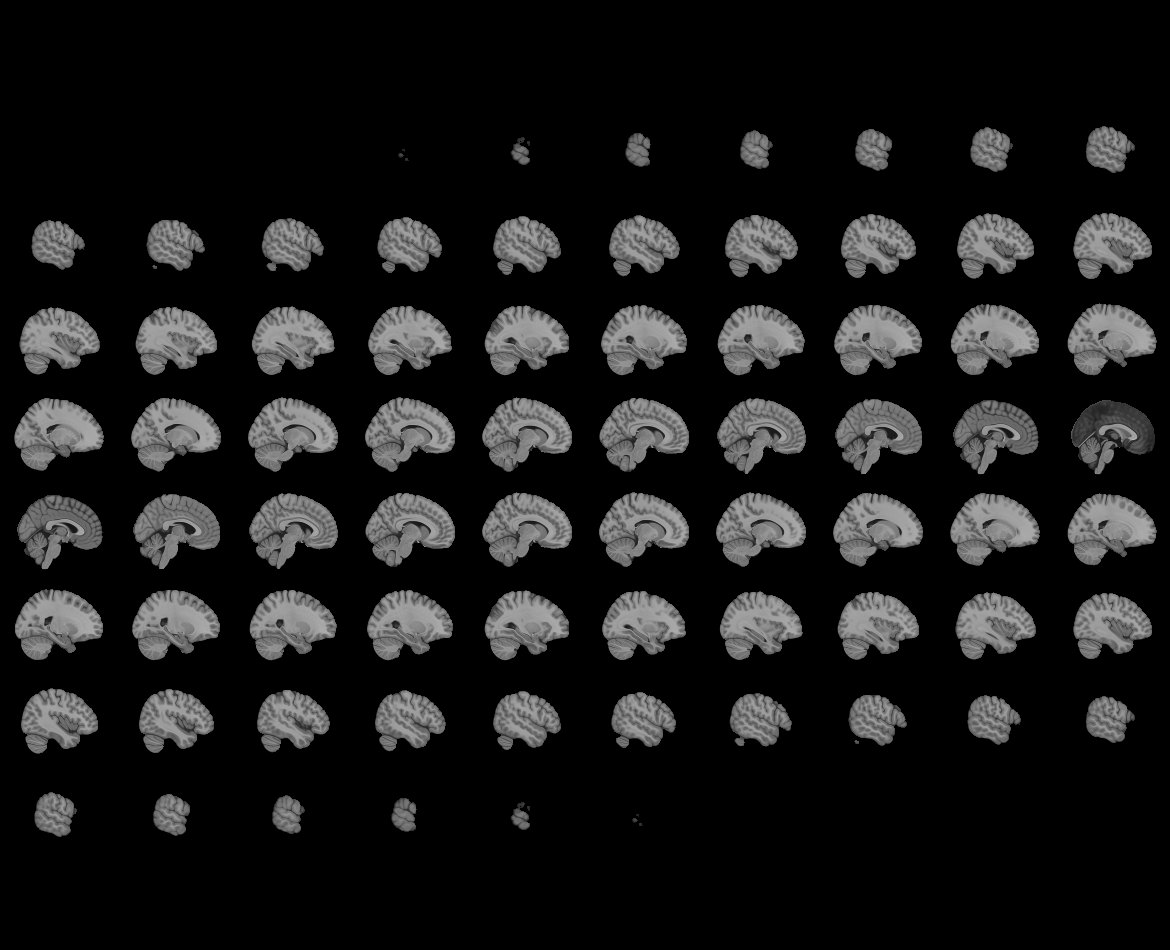
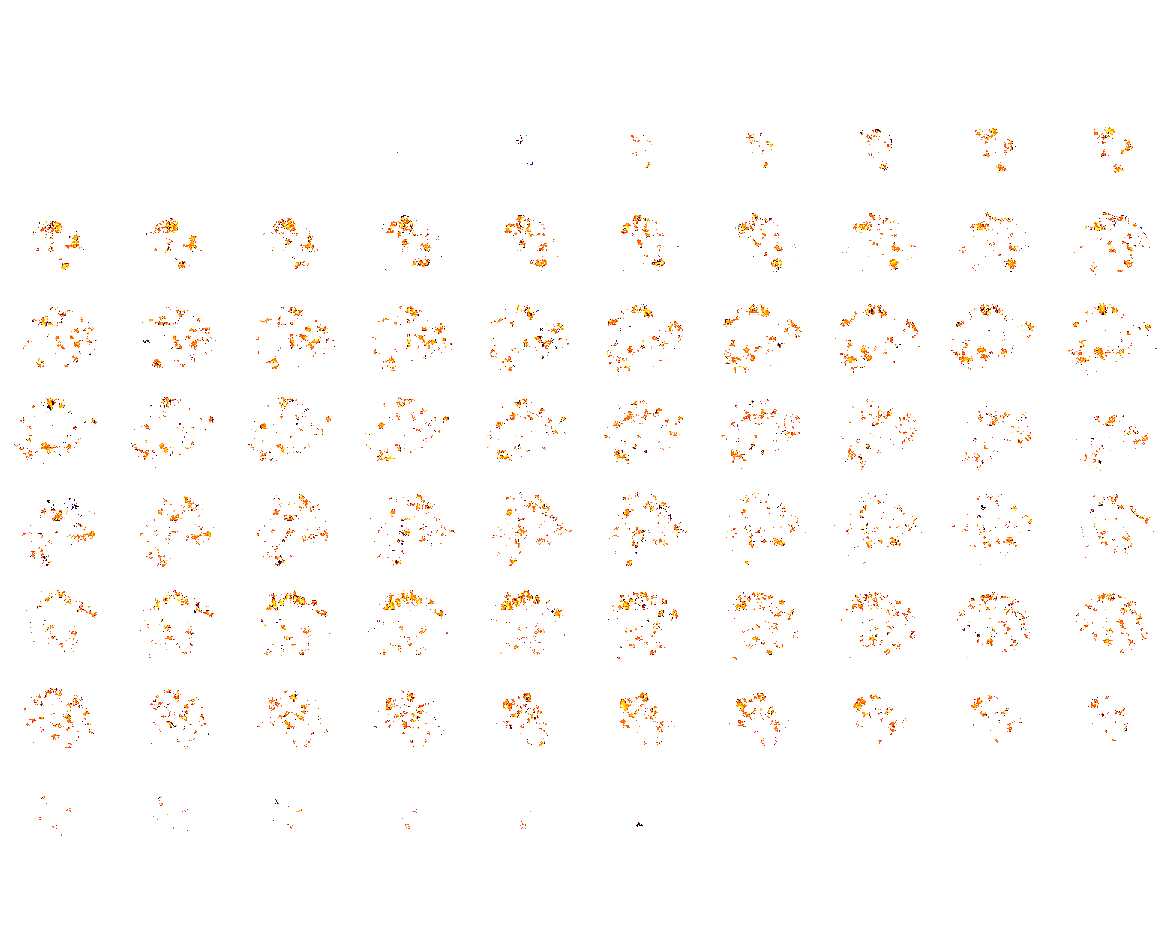

In [11]:
img_fpath = l1_fnames_groupdiff[0]
sub_name = os.path.basename(img_fpath)[:9]
plotting.view_img(img_fpath,
                  threshold=0.55,
                  cut_coords=[-42,-30,12],
                  symmetric_cmap=False,
                  title=sub_name)

In [13]:
from nilearn.image import threshold_img
from nilearn import surface
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

texture = surface.vol_to_surf(img_fpath, fsaverage.pial_right)

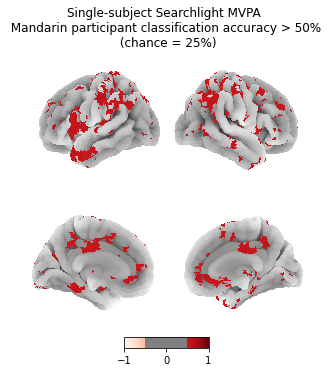

In [15]:
plotting.plot_img_on_surf(img_fpath,
                          #surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=0.50,
                          vmax=1.,
                          symm
                          cmap='Reds',
                          colorbar=True,
                          title='Single-subject Searchlight MVPA \n Mandarin participant classification accuracy > 50% \n (chance = 25%)')
plotting.show()

In [16]:
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

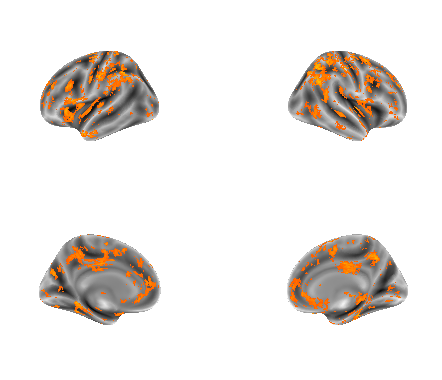

In [20]:
threshold = 0.5

fig2, axes2 = plt.subplots(nrows=2, ncols=2, subplot_kw={"projection": "3d"}, figsize=(3,2), dpi=200)
#fig2.suptitle('Mandarin-speaking group (n = {}) \n z-thresh > {}, cluster thresh > {} voxels'.format(len(sub_list_mand), threshold, cthresh))

texture_left = surface.vol_to_surf(img_fpath, fsaverage.pial_left)
texture_right = surface.vol_to_surf(img_fpath, fsaverage.pial_right)

# left hemisphere lateral view
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left',
                            #title='{} group – {} contrast'.format(group, contrast),
                            vmax=1,
                            colorbar=False,
                            threshold=threshold, 
                            view='lateral',
                            bg_map=fsaverage.sulc_left, 
                            axes=axes2[0,0], 
                            fig=fig2
                            )

# right hemisphere lateral view
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right',
                            #title='{} group – {} contrast'.format(group, contrast),
                            #colorbar=True,
                            vmax=1,
                            colorbar=False,
                            threshold=threshold, 
                            view='lateral',
                            bg_map=fsaverage.sulc_right, 
                            axes=axes2[0,1], 
                            fig=fig2
                            )

# left hemisphere medial view
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left',
                            #title='{} group – {} contrast'.format(group, contrast),
                            vmax=1,
                            colorbar=False,
                            threshold=threshold, 
                            view='medial',
                            bg_map=fsaverage.sulc_left, 
                            axes=axes2[1,0], 
                            fig=fig2
                            )

# right hemisphere medial view
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right',
                            #title='{} group – {} contrast'.format(group, contrast),
                            #colorbar=True,
                            vmax=1,
                            colorbar=False,
                            threshold=threshold, 
                            view='medial',
                            bg_map=fsaverage.sulc_right, 
                            axes=axes2[1,1], 
                            fig=fig2
                            )
fig2.tight_layout()
fig2.show()

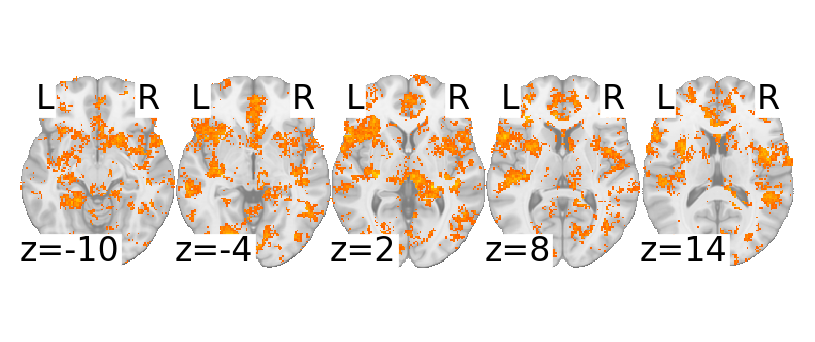

In [26]:
mni152_template = datasets.load_mni152_template(resolution=1)
fig1, ax1 = plt.subplots(figsize=(5,2), dpi=200)
plotting.plot_stat_map(img_fpath,
                       bg_img=mni152_template,
                       threshold=threshold,
                       vmax=1,
                       cut_coords=[-10, -4, 2, 8, 14],
                       display_mode='z',
                       colorbar=False, 
                       draw_cross=False, 
                       black_bg=False,
                       axes=ax1)

#### test smoothing

In [34]:
from nilearn.image import smooth_img

In [36]:
img_fpath = l1_fnames_groupdiff[0]
smoothed_img = smooth_img(img_fpath, 3)

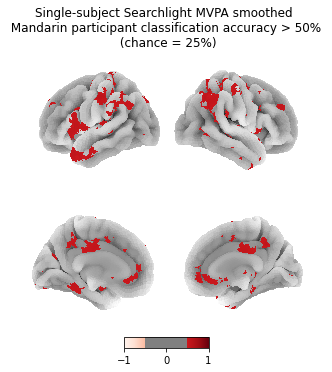

In [38]:
plotting.plot_img_on_surf(smoothed_img,
                          #surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=0.50,
                          vmax=1.,
                          cmap='Reds',
                          colorbar=True,
                          title='Single-subject Searchlight MVPA smoothed \n Mandarin participant classification accuracy > 50% \n (chance = 25%)')
plotting.show()

#### Test non-Mandarin subject

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



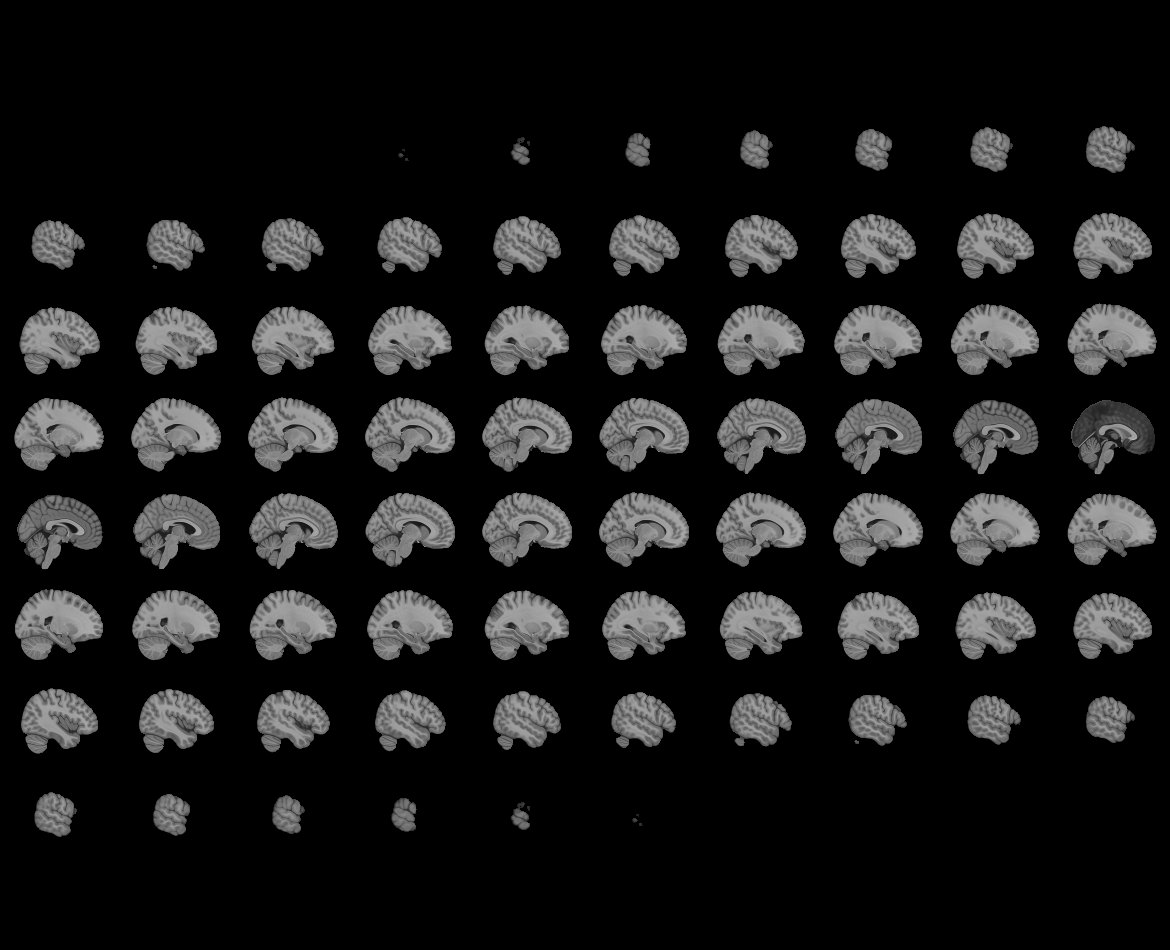
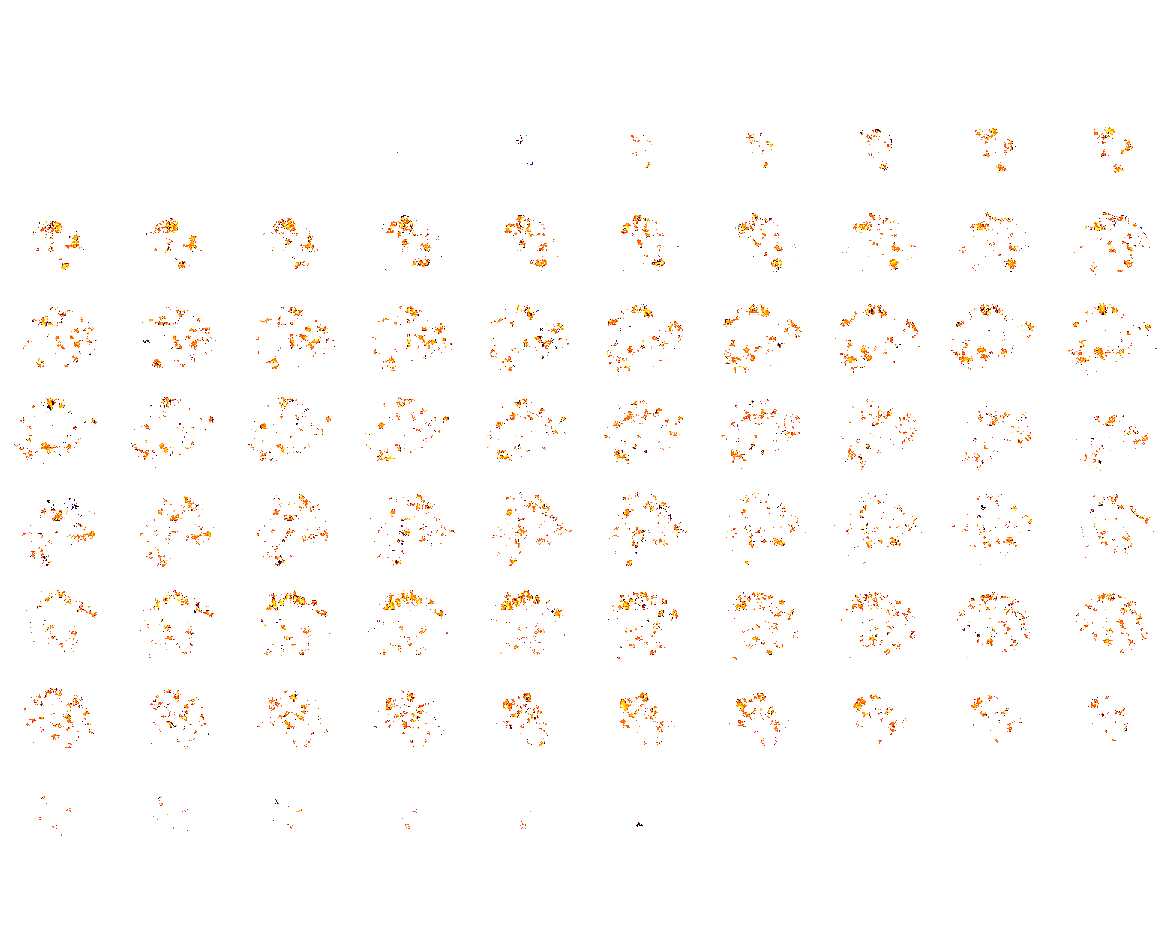

In [25]:
nmand_img_fpath = l1_fnames_groupdiff[1]
sub_name = os.path.basename(img_fpath)[:9]
plotting.view_img(img_fpath,
                  threshold=0.55,
                  cut_coords=[-42,-30,12],
                  symmetric_cmap=False,
                  title=sub_name)

In [ ]:
texture = surface.vol_to_surf(img_fpath, fsaverage.pial_right)

In [ ]:
plotting.plot_img_on_surf(img_fpath,
                          #surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=0.50,
                          cmap='Reds',
                          colorbar=True,
                          title='Single-subject Searchlight MVPA \n Non-Mandarin participant classification accuracy > 50% \n (chance = 25%)')
plotting.show()

In [ ]:
fig2, axes2 = plt.subplots(nrows=2, ncols=2, subplot_kw={"projection": "3d"}, figsize=(12,8), dpi=1000)

threshold = 0.5
cthresh = 10
thresholded_map = threshold_img(img_fpath,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=True,
                                )
texture_left = surface.vol_to_surf(thresholded_map, fsaverage.pial_left)
texture_right = surface.vol_to_surf(thresholded_map, fsaverage.pial_right)

plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left',
                            #title='{} group – {} contrast'.format(group, contrast),
                            vmax=1,
                            colorbar=True,
                            threshold=threshold, 
                            bg_map=fsaverage.sulc_left, 
                            axes=axes2[0,0], fig=fig2
                            )

plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right',
                            #title='{} group – {} contrast'.format(group, contrast),
                            #colorbar=True,
                            vmax=1,
                            colorbar=True,
                            threshold=threshold, 
                            bg_map=fsaverage.sulc_right, 
                            axes=axes2[0,1], fig=fig2
                            )

thresholded_map = threshold_img(nmand_img_fpath,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=True,
                                )
texture_left = surface.vol_to_surf(thresholded_map, fsaverage.pial_left)
texture_right = surface.vol_to_surf(thresholded_map, fsaverage.pial_right)

plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left',
                            #title='{} group – {} contrast'.format(group, contrast),
                            vmax=1,
                            colorbar=True,
                            threshold=threshold, 
                            bg_map=fsaverage.sulc_left, 
                            axes=axes2[1,0], fig=fig2
                            )

plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right',
                            #title='{} group – {} contrast'.format(group, contrast),
                            #colorbar=True,
                            vmax=1,
                            colorbar=True,
                            threshold=threshold, 
                            bg_map=fsaverage.sulc_right, 
                            axes=axes2[1,1], fig=fig2
                            )
fig2.savefig('single_subject_group_comp_searchlight.png')

## WIP: comparison vs. permuted values

Per [Stelzer et al. (2013)](https://doi.org/10.1016/j.neuroimage.2012.09.063):
> On the single subject level, we employed permutation tests. It is important to highlight that the permutation tests in our method do not serve as a direct means to infer statistical significance on a single subject level, rather they should be regarded as an intermediate module for subsequent group recombination and inference methods (see Fig. 1 for an overview). The reasoning behind permutation tests on a single subject level is to assess chance distributions and chance accuracy maps (Chen et al., 2011, Golland and Fischl, 2003). For this, we created a random permutation of the observation order and applied it to the data set (see Fig. 2 for an overview of the permutation scheme).

Participant-level steps: 
1) Get searchlight accuracies
2) Permute labels and run searchlight (100 times)


In [ ]:
# load participant-level permuted chance maps (computed outside this notebook)
chance_maps_dict = {}
for sx, sub_id in enumerate(sub_list):
    permutation_dir = []
    sub_chance_maps = sorted(glob(permutation_dir))
    chance_maps_dict[sub_id, sub_chance_maps]

**problem**: 

## WIP: parametric accuracy minus chance

In [1]:
# loop through images and subtract 0.25 (chance) if above chance

In [19]:
from nilearn.image import new_img_like

In [20]:
chance_acc = 0.25
diff_img_list = []

for mask_label in ['gm_cond-tone']:
    print(mask_label)
    mask_sl_thr_array = []

    for sx, sub_id in enumerate(subjects_label):
        sub_mask_sl_fpath = os.path.join(nilearn_dir, 'level-1_fwhm-1.50', '%s_space-%s'%(sub_id, space_label), search_label, 
                                         '{}_space-{}_mask-{}_searchlight.nii.gz'.format(sub_id, space_label, mask_label))
        sub_sl_img = nib.load(sub_mask_sl_fpath)

        sub_sl_data = sub_sl_img.get_fdata()

        # subtract chance accuracies
        diff_data = sub_sl_data - chance_acc
        # if below 0, move to 0 (no such thing as negative chance)
        diff_data[diff_data < 0] = 0

        diff_img = new_img_like(sub_sl_img, diff_data)

        diff_img_list.append(diff_img)

gm_cond-tone


In [21]:
second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0,], output_type='z_score')

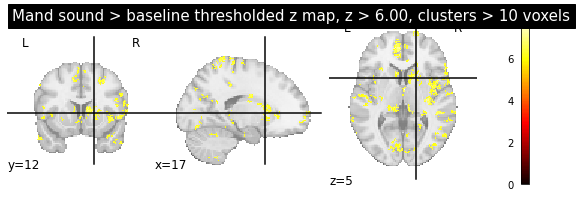

In [26]:
from nilearn.image import threshold_img
threshold = 6
cthresh = 10
thresholded_map = threshold_img(
                                z_map,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=False,
                            )

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



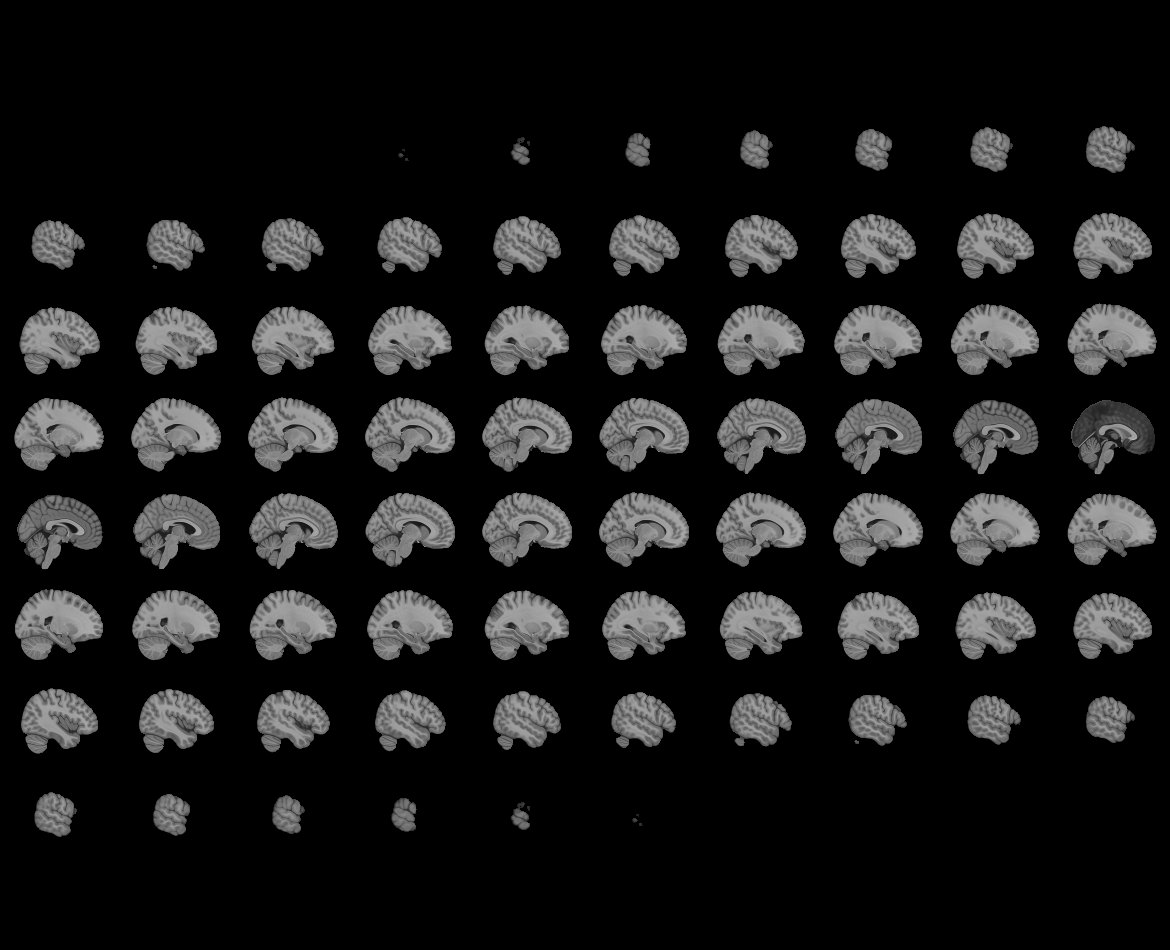
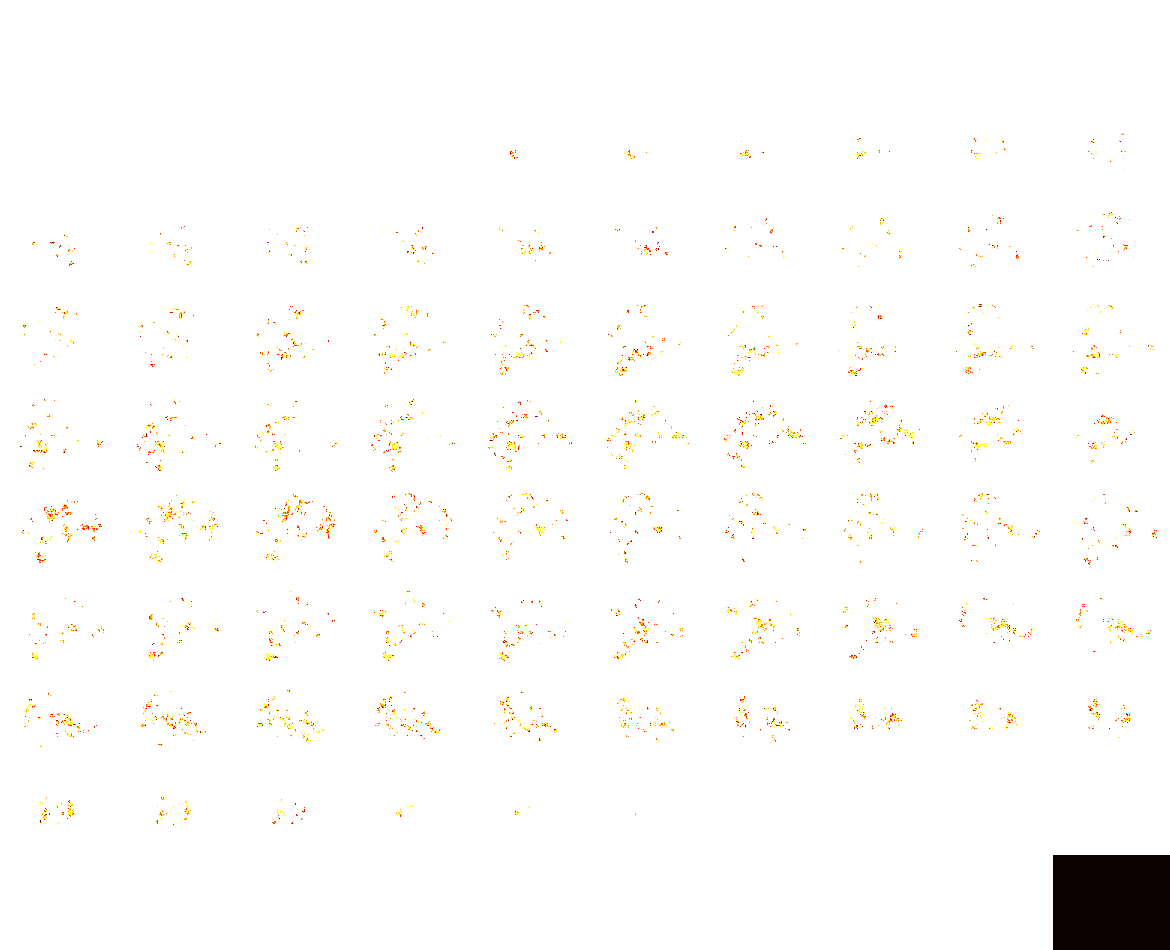

In [28]:
plotting.view_img(thresholded_map)

## test: group overlap

In [10]:
search_label

'searchlight_radius-9'

In [22]:
thr_acc = 0.45

fwhm = 1.5
space_label = 'MNI152NLin2009cAsym'

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm)

for group_label in ['mand']: # ['mand', 'nman']
    group_mask_sl_thr = []
    if group_label == 'mand':
        sub_loop_list = sub_list_mand
    elif group_label == 'nman':
        sub_loop_list = sub_list_nman

    for mask_label in ['gm_cond-tone']:
        print(mask_label)
        mask_sl_thr_array = []

        for sx, sub_id in enumerate(sub_loop_list):
            sub_mask_sl_fpath = os.path.join(nilearn_dir, '%s_space-%s'%(sub_id, space_label), search_label, 
                                             '{}_space-{}_mask-{}_searchlight.nii.gz'.format(sub_id, space_label, mask_label))
            sub_sl_img = nib.load(sub_mask_sl_fpath)

            sub_sl_data = sub_sl_img.get_fdata()

            # threshold/binarize
            sub_sl_thr = np.where(sub_sl_data > thr_acc, 1, 0)
            mask_sl_thr_array.append(sub_sl_thr)

        # create a group count image
        group_mask_sl_thr = np.sum(mask_sl_thr_array, axis=0)
        group_sl_img = nib.Nifti1Image(group_mask_sl_thr, affine=sub_sl_img.affine)
        group_sl_dir = os.path.join(nilearn_dir, 'searchlight_group')
        if not os.path.exists(group_sl_dir):
                os.makedirs(group_sl_dir)
        group_sl_fpath = os.path.join(group_sl_dir, 'group-{}_mask-{}_{}_thr-{}.nii.gz'.format(group_label, mask_label, search_label, thr_acc))
        #nib.save(group_sl_img, group_sl_fpath)
        #print('saved group image to ', group_sl_fpath)

gm_cond-tone


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



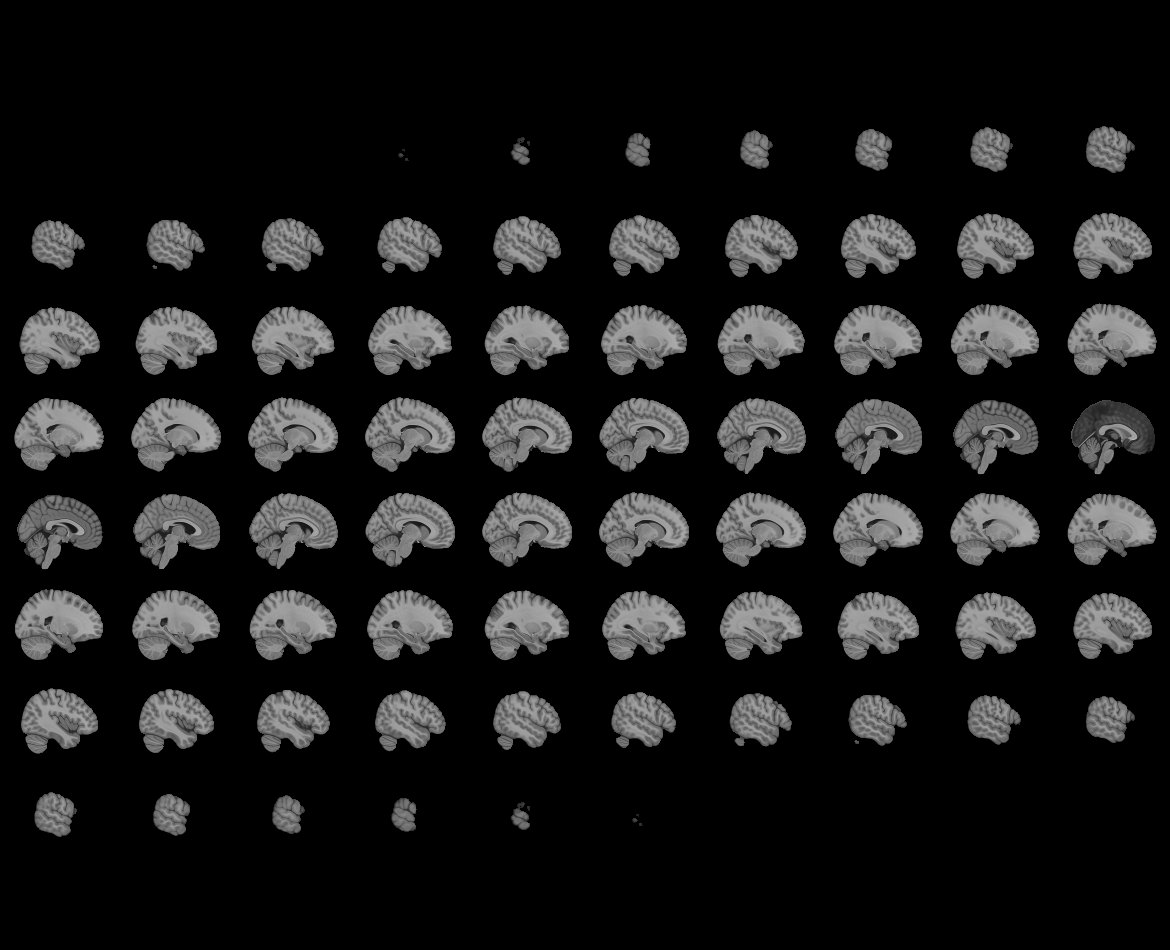
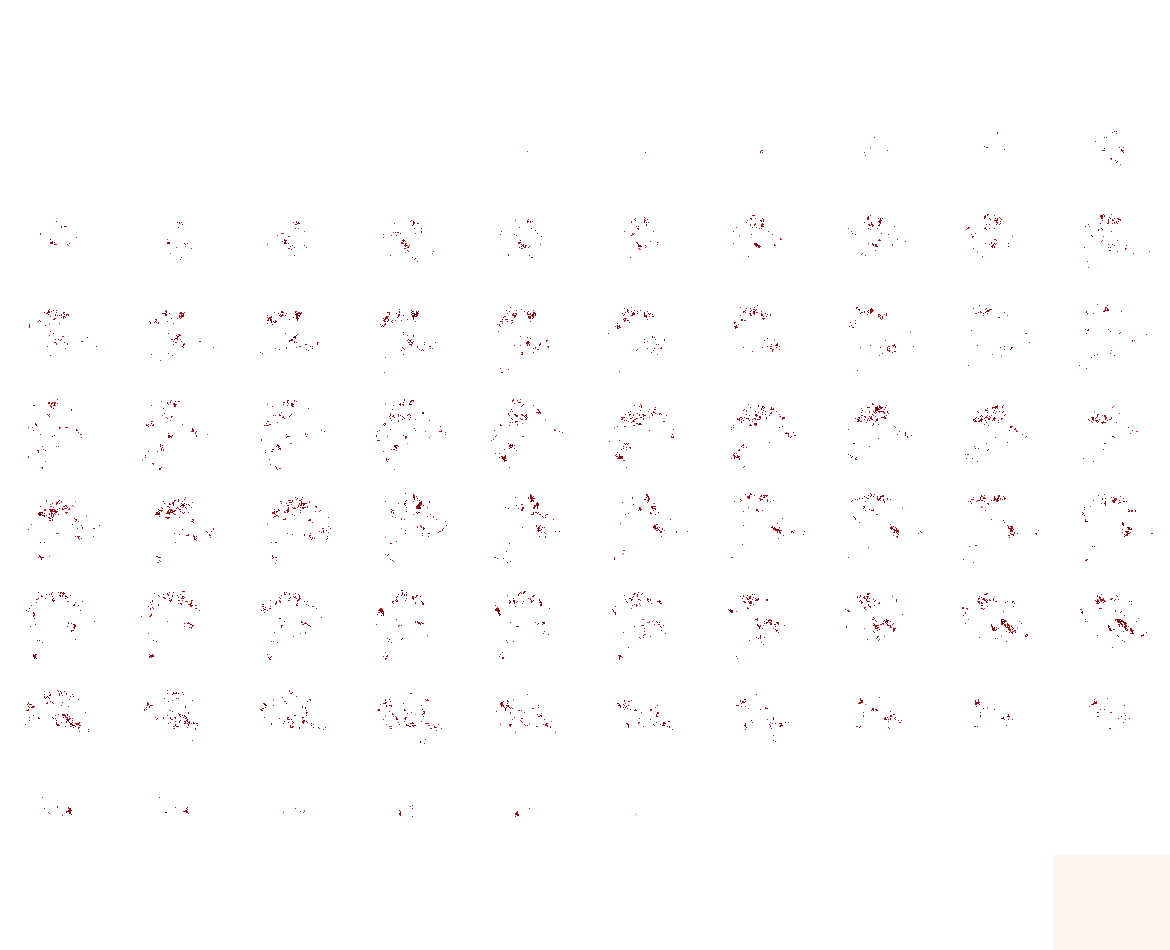

In [26]:
plotting.view_img(group_sl_img,
                  symmetric_cmap=False,
                  cmap='Reds',
                  threshold=8)

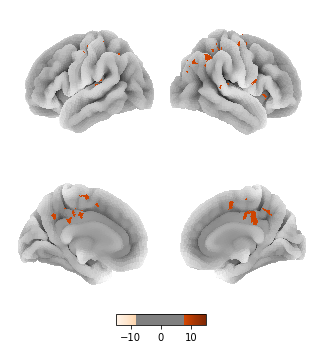

In [27]:
plotting.plot_img_on_surf(group_sl_img,
                          surf_mesh='fsaverage5',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=8,
                          vmax=15,
                          colorbar=True,
                          cmap='Oranges',
                         )
plotting.show()

In [31]:
mni152_template = datasets.load_mni152_template(resolution=1)

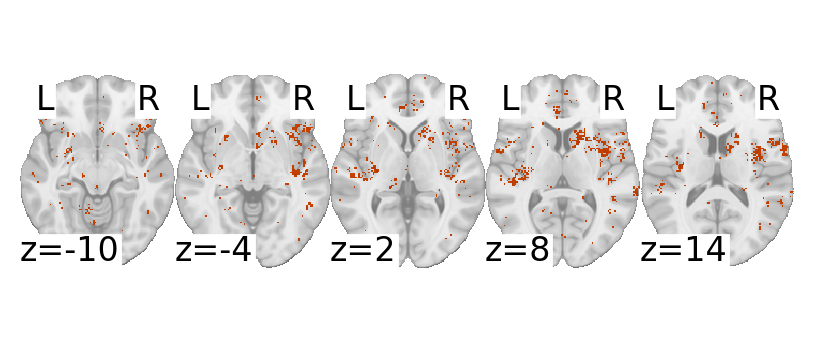

In [32]:
fig1, ax1 = plt.subplots(figsize=(5,2), dpi=200)
plotting.plot_stat_map(group_sl_img,
                       bg_img=mni152_template,
                       threshold=8,
                       vmax=15,
                       cmap='Oranges',
                       cut_coords=[-10, -4, 2, 8, 14],
                       display_mode='z',
                       colorbar=False, 
                       draw_cross=False, 
                       black_bg=False,
                       axes=ax1)

#### Non-Mandarin-speaking participants

In [27]:
thr_acc = 0.5

fwhm = 1.5
space_label = 'MNI152NLin2009cAsym'

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm)

for group_label in ['nman']:
    group_mask_sl_thr = []
    if group_label == 'mand':
        sub_loop_list = sub_list_mand
    elif group_label == 'nman':
        sub_loop_list = sub_list_nman

    for mask_label in ['gm_cond-tone']:
        print(mask_label)
        mask_sl_thr_array = []

        for sx, sub_id in enumerate(sub_loop_list):
            sub_mask_sl_fpath = os.path.join(nilearn_dir, '%s_space-%s'%(sub_id, space_label), search_label, 
                                             '{}_space-{}_mask-{}_searchlight.nii.gz'.format(sub_id, space_label, mask_label))
            sub_sl_img = nib.load(sub_mask_sl_fpath)

            sub_sl_data = sub_sl_img.get_fdata()

            # threshold/binarize
            sub_sl_thr = np.where(sub_sl_data > thr_acc, 1, 0)
            mask_sl_thr_array.append(sub_sl_thr)

        # create a group count image
        group_mask_sl_thr = np.sum(mask_sl_thr_array, axis=0)
        group_sl_img = nib.Nifti1Image(group_mask_sl_thr, affine=sub_sl_img.affine)
        group_sl_dir = os.path.join(nilearn_dir, 'searchlight_group')
        if not os.path.exists(group_sl_dir):
                os.makedirs(group_sl_dir)
        group_sl_fpath = os.path.join(group_sl_dir, 'group-{}_mask-{}_{}_thr-{}.nii.gz'.format(group_label, mask_label, search_label, thr_acc))
        nib.save(group_sl_img, group_sl_fpath)
        print('saved group image to ', group_sl_fpath)

gm_cond-tone
saved group image to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/searchlight_group/group-nman_mask-gm_cond-tone_searchlight_radius-6_thr-0.5.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



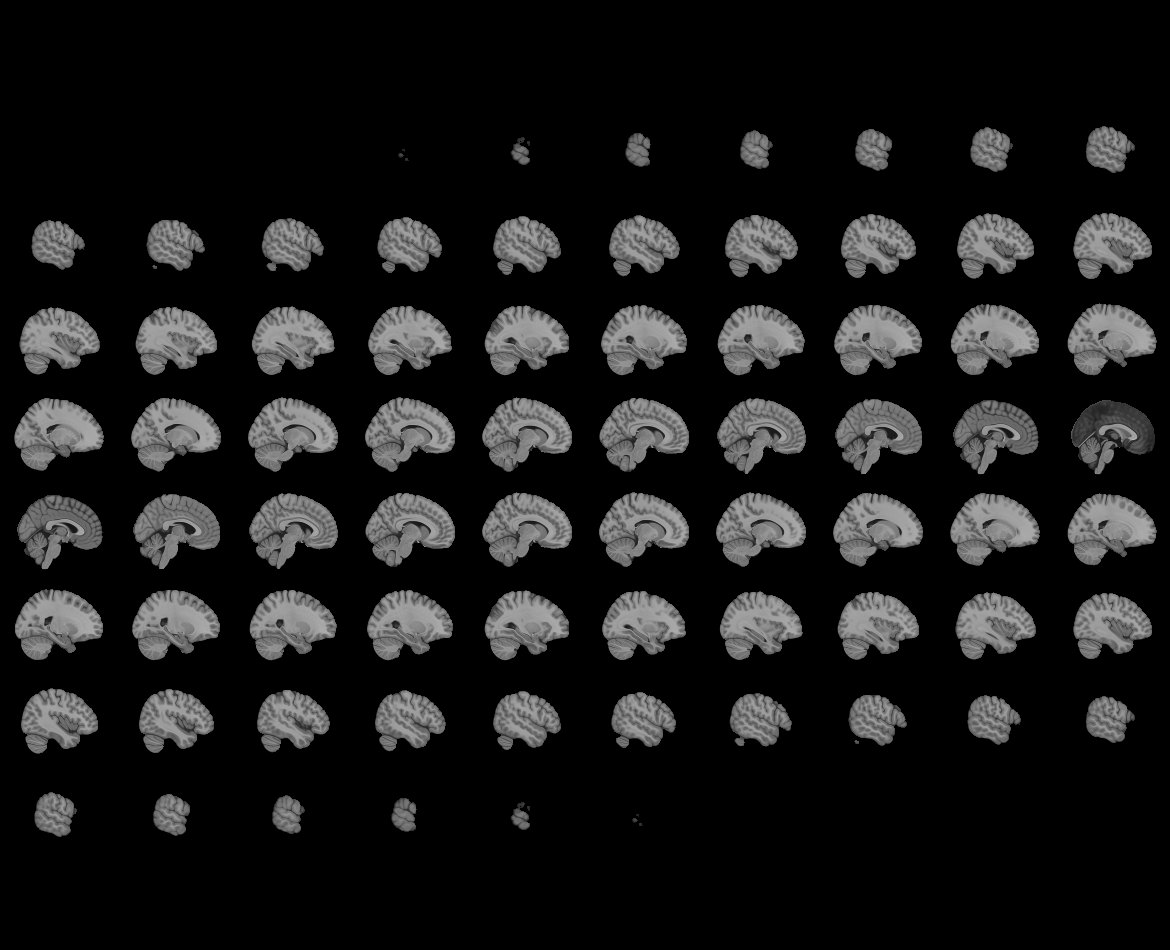
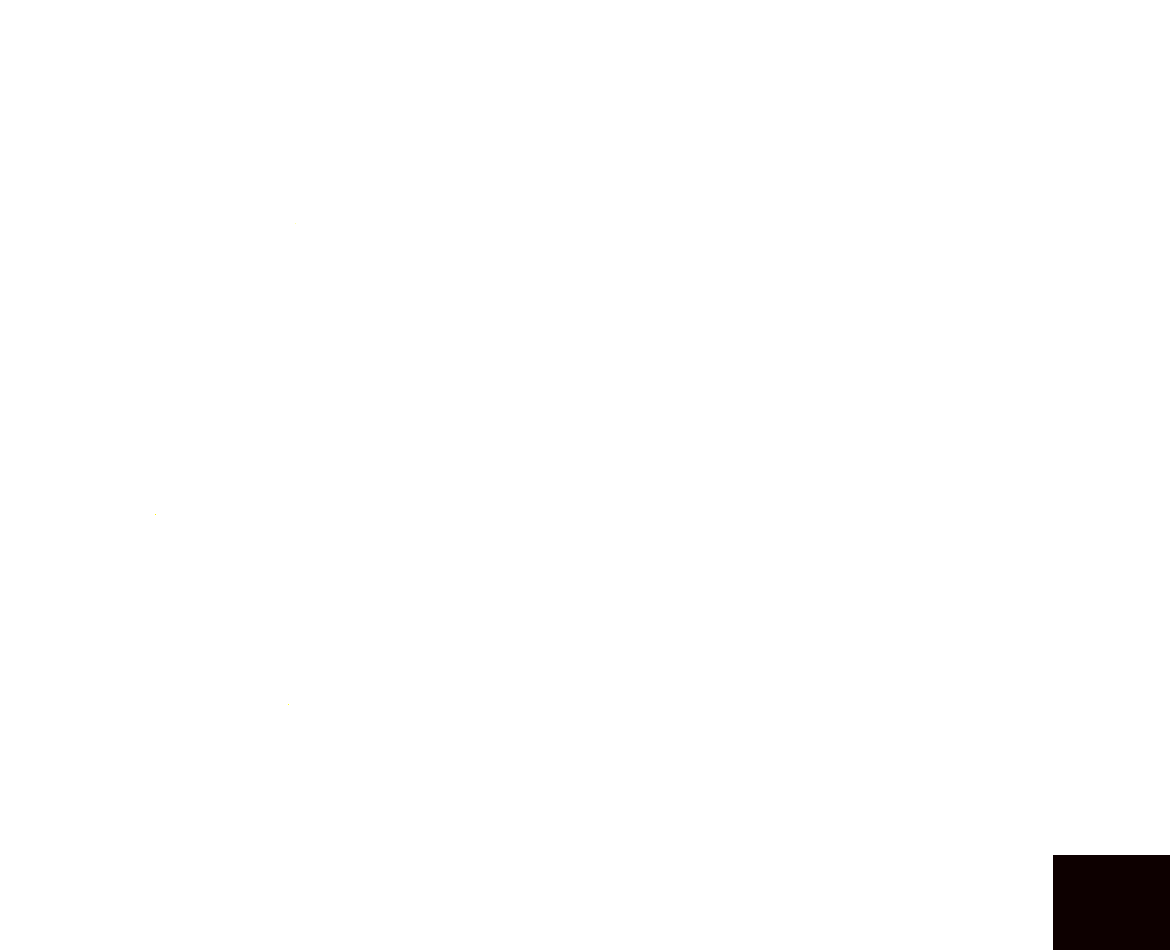

In [28]:
plotting.view_img(group_sl_img,
                  threshold=2)

#### NOT WORKING – plotting from saved group files. currently plotting means or something, not overlaps

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



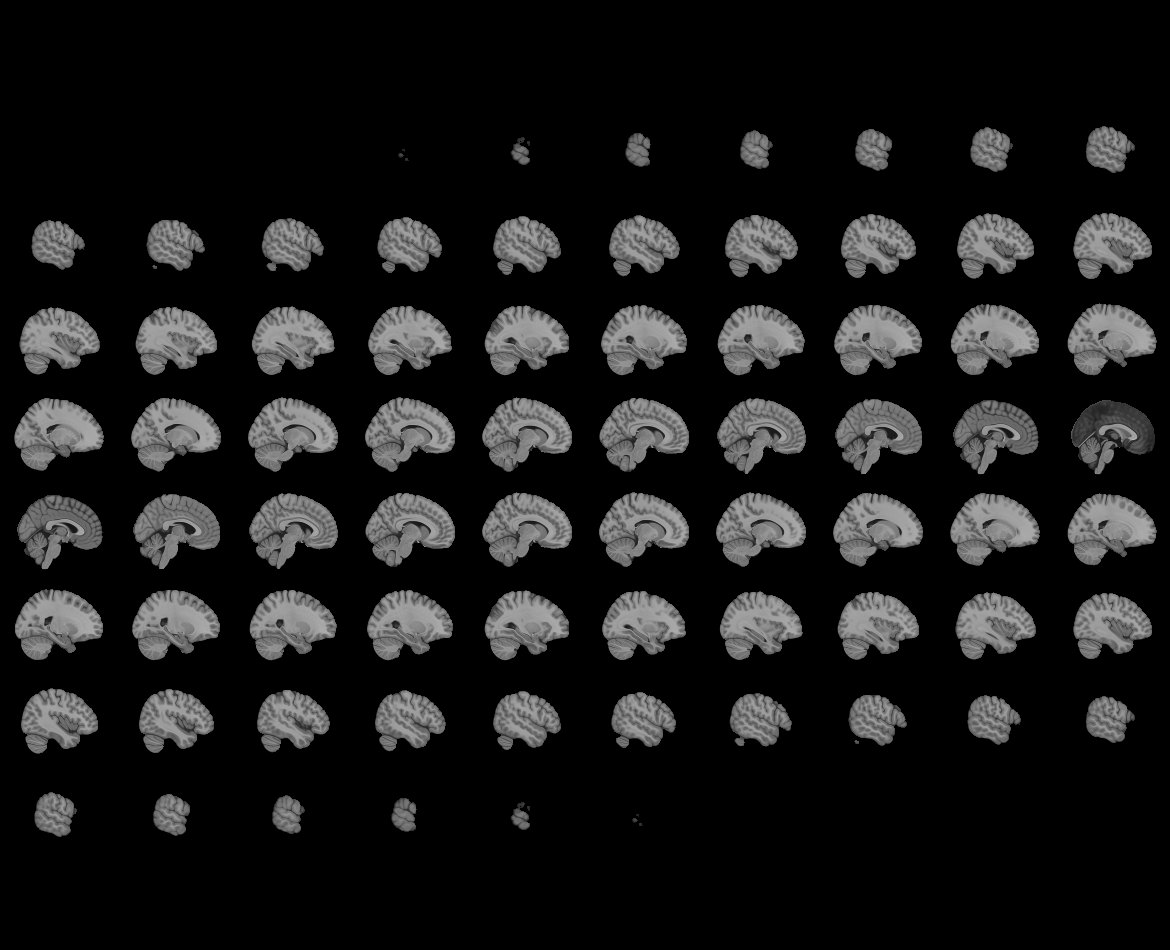
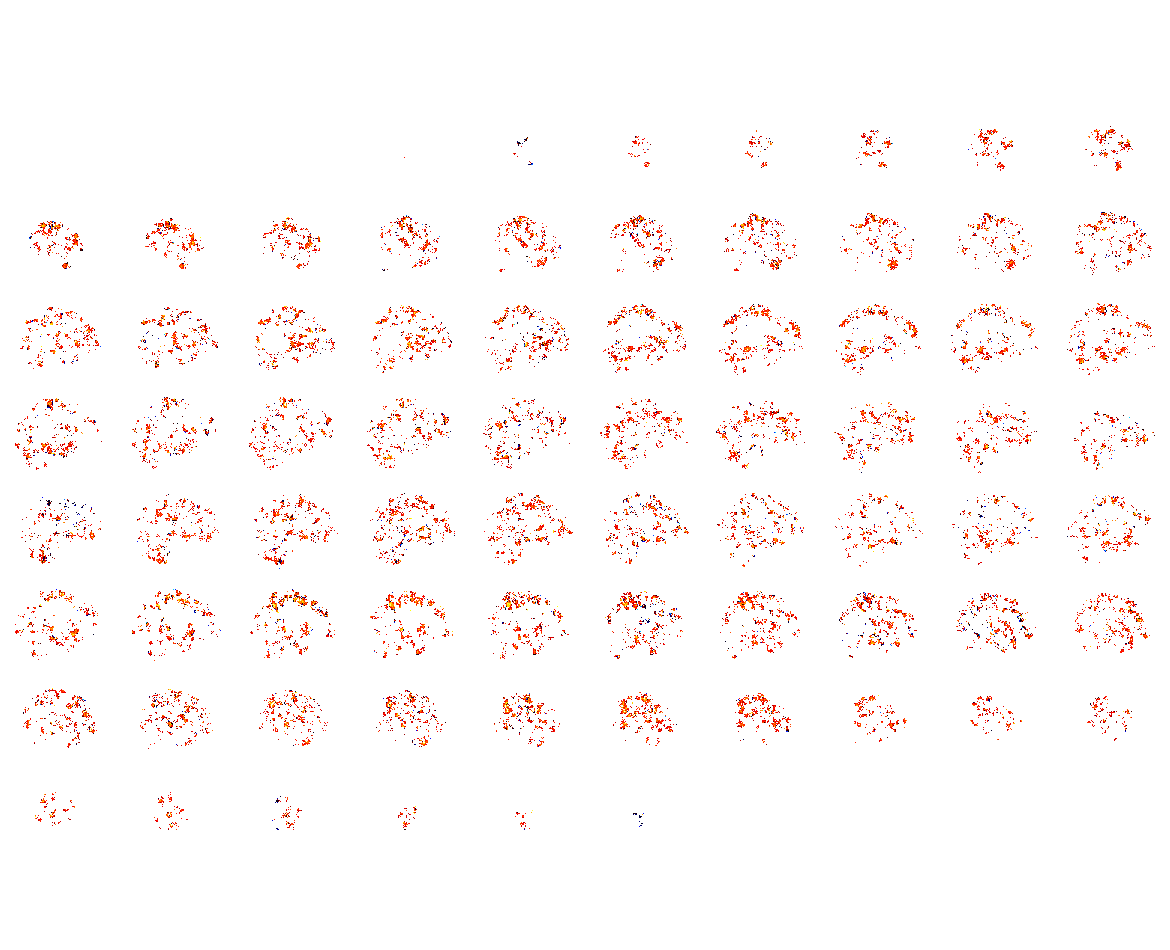

In [29]:
group_img_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/',
                               'derivatives/nilearn/level-1_fwhm-1.50/searchlight_group/',
                               'group-mand_mask-gm_cond-tone_{}_thr-0.5.nii.gz'.format(search_label))
plotting.view_img(img_fpath,
                  threshold=0.5,
                  cut_coords=[-42,-30,12],
                  symmetric_cmap=False,
                  title='Mandarin')

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



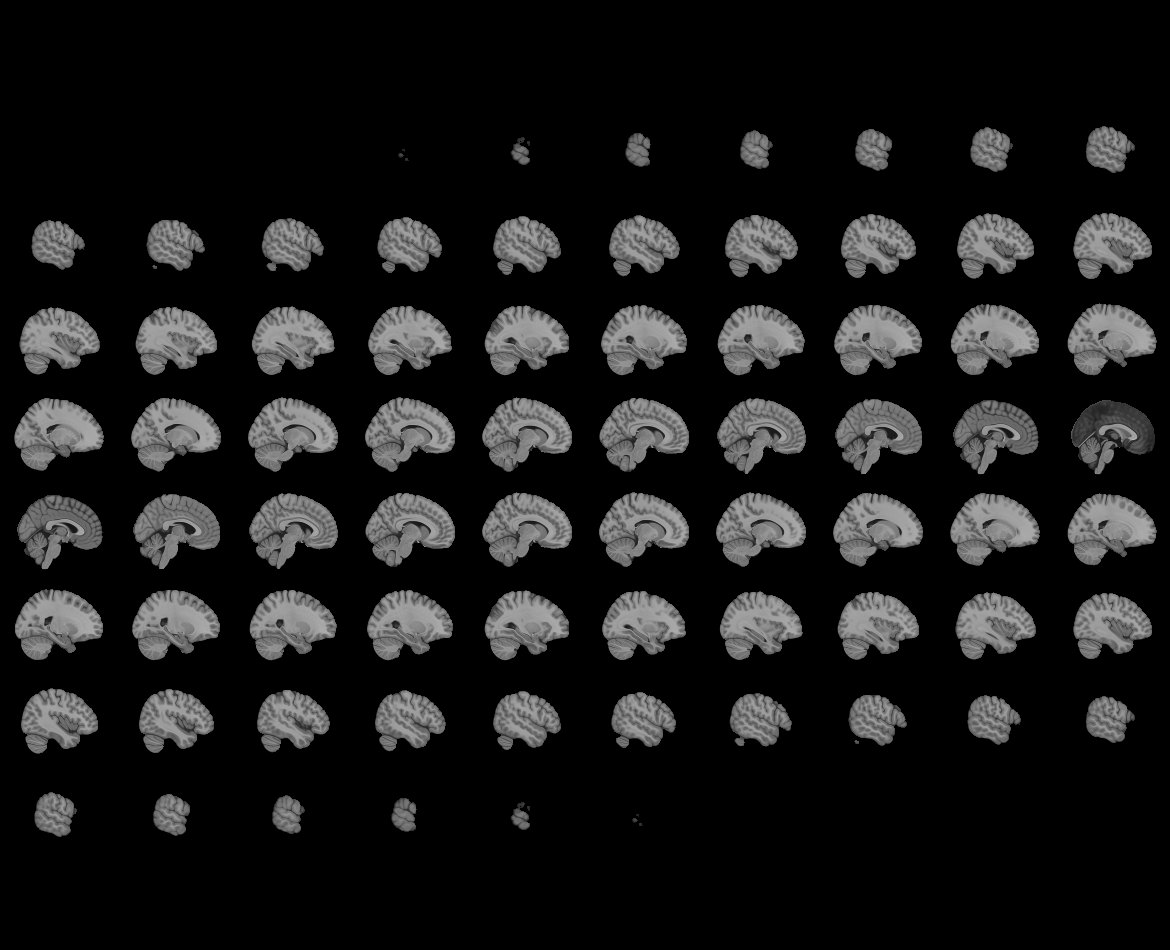
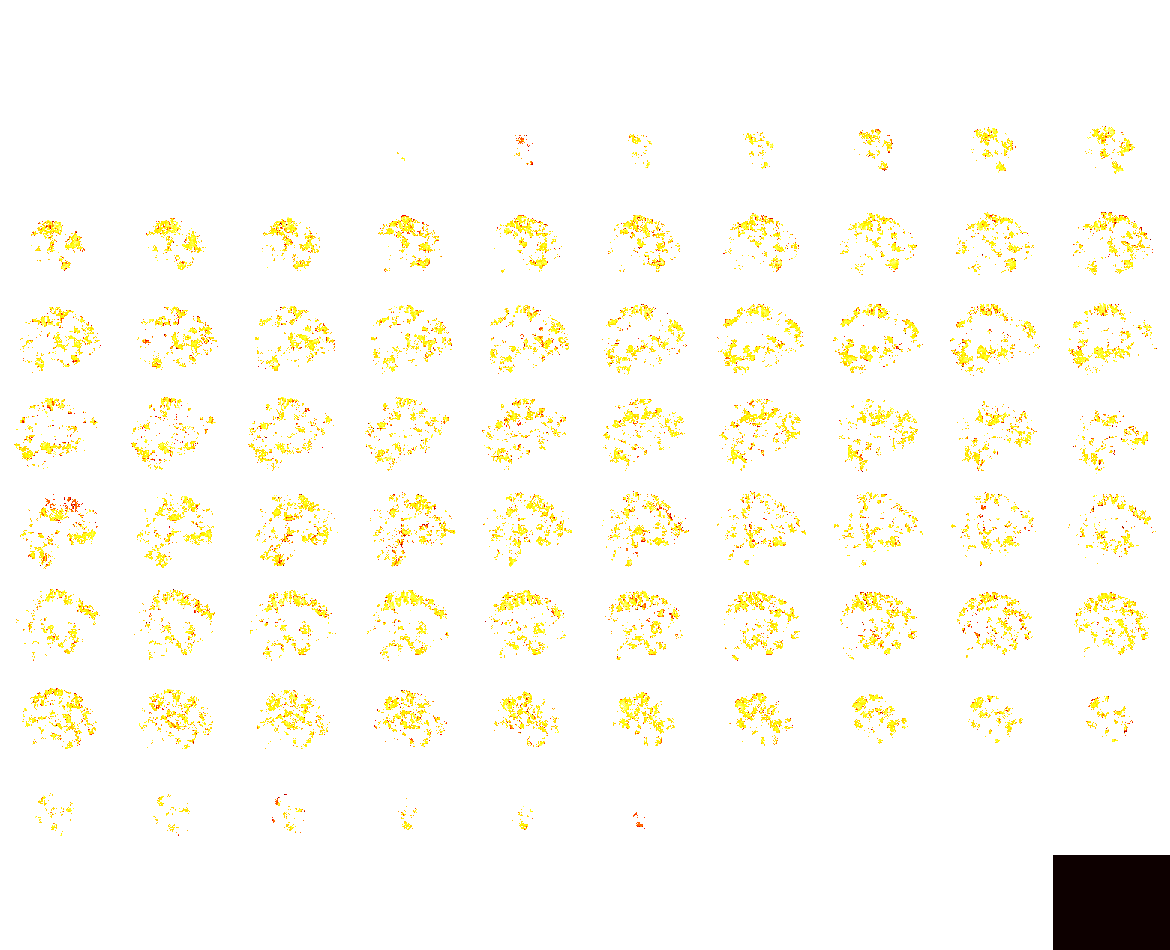

In [125]:
group_img_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/',
                               'derivatives/nilearn/level-1_fwhm-1.50/searchlight_group/',
                               'group-nman_mask-gm_cond-tone_searchlight_radius-9_thr-0.5.nii.gz')
plotting.view_img(img_fpath,
                  threshold=0.5,
                  cut_coords=[-42,-30,12],
                  symmetric_cmap=False,
                  title='non-Mandarin')

### test: parametric t-tests

In [39]:
smoothed_l1_fnames_groupdiff = smooth_img(l1_fnames_groupdiff, 3)

In [40]:
second_level_model = SecondLevelModel().fit(smoothed_l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)
#second_level_model = SecondLevelModel().fit(l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)

#z_map = second_level_model.compute_contrast(second_level_contrast='group', output_type='z_score')
z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0,], output_type='z_score')

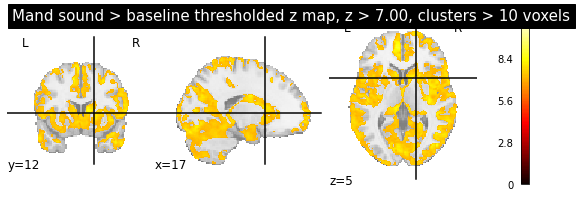

In [43]:
from nilearn.image import threshold_img
threshold = 7 # 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=False,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

## Permutation tests

In [44]:
from nilearn.glm.second_level import non_parametric_inference

### Mandarin-speaking group:

In [45]:
-np.log10(1 / 1000)

3.0

In [46]:
log_pvals_permuted_ols_unmasked = \
    non_parametric_inference(smoothed_l1_fnames_groupdiff, # l1_fnames_groupdiff, 
                             design_matrix=design_mat_groupdiff,
                             second_level_contrast=[1,0],
                             n_perm=1000,
                             n_jobs=1)

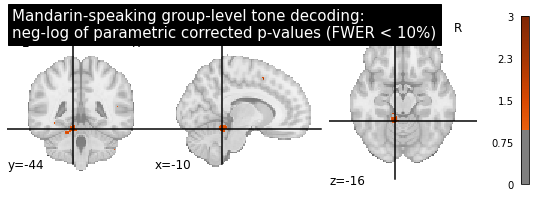

In [48]:
threshold = 1.0
title = ('Mandarin-speaking group-level tone decoding: \n'
         'neg-log of parametric corrected p-values (FWER < 10%)')
plotting.plot_stat_map(log_pvals_permuted_ols_unmasked, 
                       colorbar=True, 
                       threshold=threshold, 
                       #cut_coords=cut_coords, 
                       title=title,
                       cmap='Oranges',
                      )
plotting.show()

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



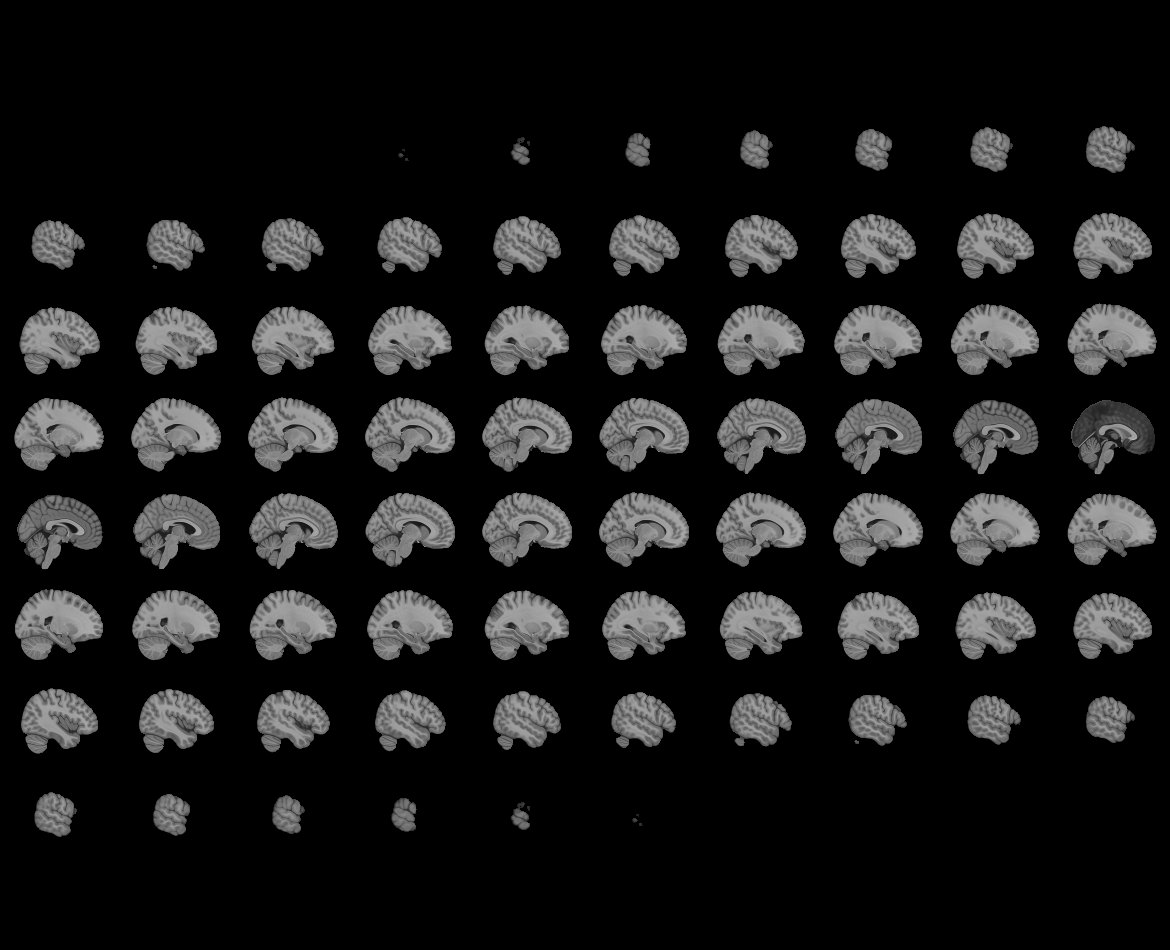
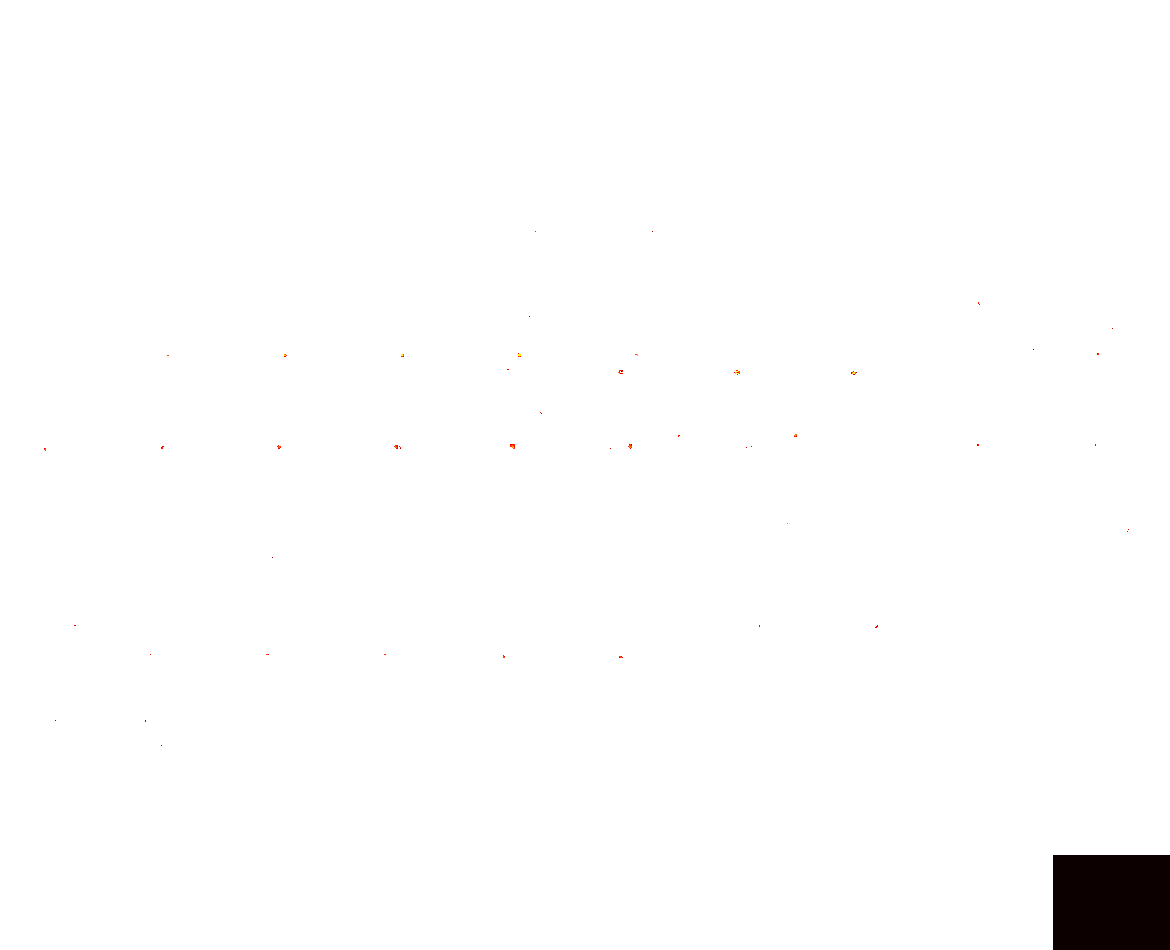

In [49]:
 plotting.view_img(log_pvals_permuted_ols_unmasked,
                  threshold=1)

### Non-Mandarin speaking group:

In [36]:
log_pvals_permuted_ols_unmasked = \
    non_parametric_inference(l1_fnames, 
                             design_matrix=design_mat_groupdiff,
                             second_level_contrast=[0,1],
                             n_perm=1000,
                             n_jobs=1)

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/mass_univariate/_utils.py:426: RuntimeWarning: divide by zero encountered in true_divide
  return beta_targetvars_testedvars * np.sqrt((dof - 1.) / rss)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/mass_univariate/_utils.py:426: RuntimeWarning: invalid value encountered in sqrt
  return beta_targetvars_testedvars * np.sqrt((dof - 1.) / rss)


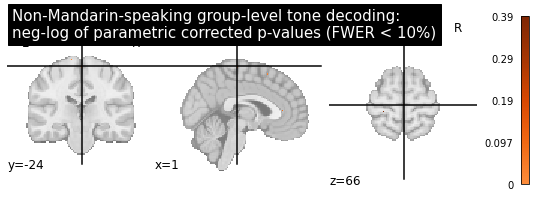

In [37]:
threshold = 1.
title = ('Non-Mandarin-speaking group-level tone decoding: \n'
         'neg-log of parametric corrected p-values (FWER < 10%)')
plotting.plot_stat_map(log_pvals_permuted_ols_unmasked, colorbar=True, 
                       #threshold=threshold, 
                       #cut_coords=cut_coords, 
                       title=title,
                       cmap='Oranges',
                      )
plotting.show()

### Group differences

In [39]:
log_pvals_permuted_ols_unmasked = \
    non_parametric_inference(l1_fnames_groupdiff, 
                             design_matrix=design_mat_groupdiff,
                             second_level_contrast=[1, 0], #'group',
                             n_perm=1000,
                             n_jobs=1)

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/mass_univariate/_utils.py:426: RuntimeWarning: divide by zero encountered in true_divide
  return beta_targetvars_testedvars * np.sqrt((dof - 1.) / rss)


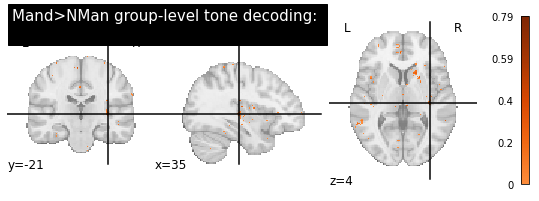

In [41]:
threshold = 1.0
title = ('Mand>NMan group-level tone decoding: \n'
         #'neg-log of parametric corrected p-values (FWER < 10%)'
        )
plotting.plot_stat_map(log_pvals_permuted_ols_unmasked, colorbar=True, 
                       #threshold=threshold, 
                       #cut_coords=cut_coords, 
                       title=title,
                       cmap='Oranges',
                      )
plotting.show()

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



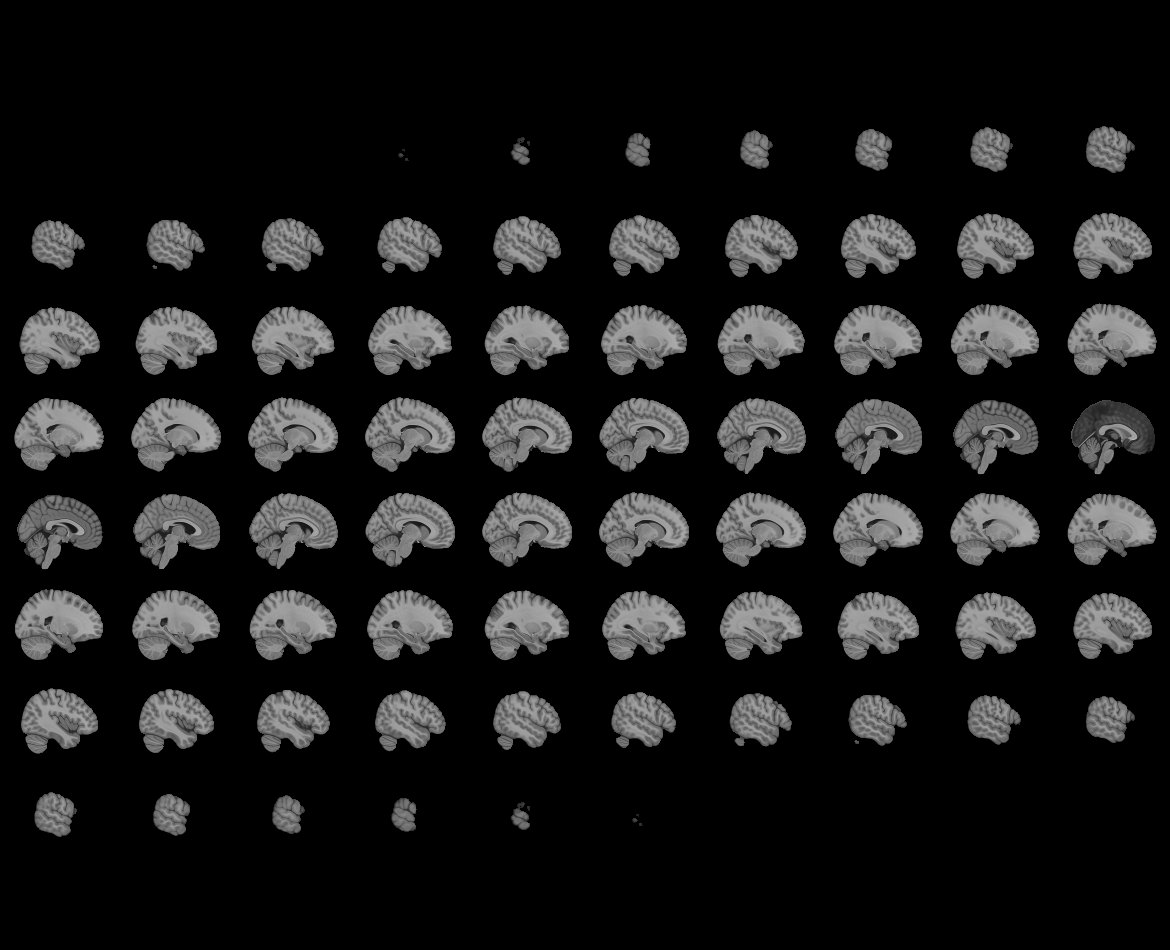
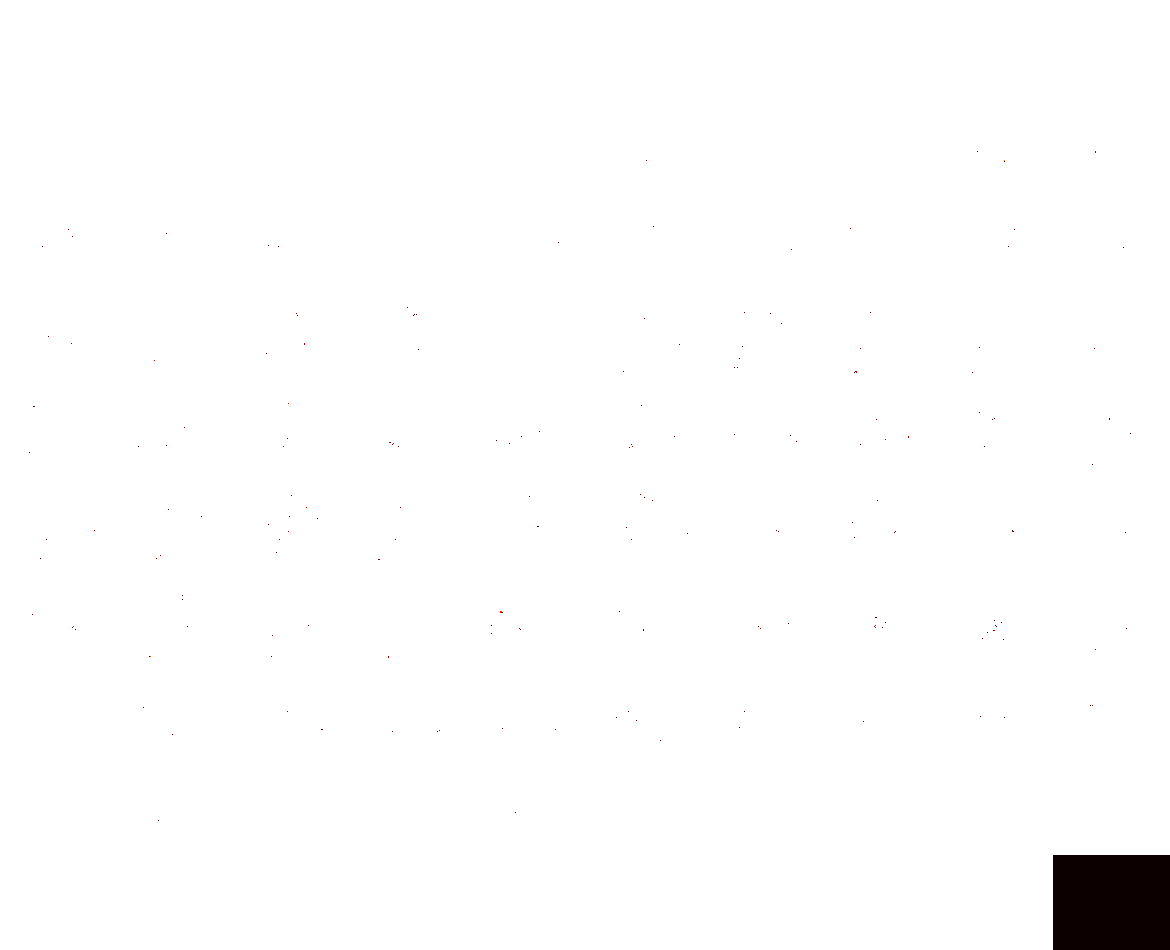

In [44]:
plotting.view_img(log_pvals_permuted_ols_unmasked, 
                  threshold=0.1, 
                  cut_coords=[17,12,5],
                  title='Mand > NMan classification')

### All participants

In [ ]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(l1_fnames, design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn import plotting
display = plotting.plot_stat_map(z_map, title='Raw z map - %s > baseline'%contrast_label)

In [ ]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='%s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

In [ ]:
from nilearn.glm import threshold_stats_img
fpr_alpha = .01
cthresh = 10
thresholded_map1, \
    threshold1 = threshold_stats_img(
                                    z_map,
                                    alpha=fpr_alpha,
                                    height_control='fpr',
                                    cluster_threshold=cthresh,
                                    two_sided=True,
                                    )
plotting.plot_stat_map(
    thresholded_map1, cut_coords=display.cut_coords, threshold=threshold1,
    title='%s > baseline thresholded z map, fpr <%.03f, clusters > %d voxels'%(contrast_label, fpr_alpha, cthresh))
print(threshold1)

In [ ]:
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

plotting.plot_stat_map(thresholded_map2, cut_coords=display.cut_coords,
                       title='%s > baseline thresholded z map, expected fdr = .05'%contrast_label,
                       threshold=threshold2)

### Surface plots

In [ ]:
from nilearn import datasets, surface

In [ ]:
big_fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
big_texture = surface.vol_to_surf(z_map, big_fsaverage.pial_right)

plotting.plot_surf_stat_map(big_fsaverage.infl_right,
                            big_texture, hemi='right', colorbar=True,
                            title='Surface right hemisphere: fine mesh',
                            threshold=2.58, bg_map=big_fsaverage.sulc_right)
plotting.show()

In [ ]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=1.96, #2.58,
                          colorbar=True)
plotting.show()

In [ ]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=1, #2.58,
                          colorbar=True)
plotting.show()